In [1]:
import os
from google.colab import drive

drive.mount('/content/drive')
os.chdir('drive/My Drive/Colab Notebooks/AI RESIDENCY/P5/Russia')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
from functions import *

In [3]:
## Daily
with open('train_data_russia.pkl', 'rb') as f:
    train_data_russia = pickle.load(f)

with open('test_data_russia.pkl', 'rb') as f:
    test_data_russia = pickle.load(f)

# ## Weekly
# with open('train_weekly_russia.pkl', 'rb') as f:
#     train_weekly_russia = pickle.load(f)

# with open('test_weekly_russia.pkl', 'rb') as f:
#     test_weekly_russia = pickle.load(f)

# ## Monthly
# with open('train_monthly_russia.pkl', 'rb') as f:
#     train_monthly_russia = pickle.load(f)

# with open('test_monthly_russia.pkl', 'rb') as f:
#     test_monthly_russia = pickle.load(f)

In [4]:
train_data_russia.head()

,Date,Price,Open,High,Low,Vol.,Change %,quarter,month,week
0,2020-01-06,253.90,254.75,254.84,251.40,22350000.0,-0.43%,1,1,2
1,2020-01-08,259.15,253.57,259.15,253.03,40820000.0,2.07%,1,1,2
2,2020-01-09,257.99,259.40,261.76,257.01,38330000.0,-0.45%,1,1,2
3,2020-01-10,258.19,257.86,259.25,256.88,18850000.0,0.08%,1,1,2
4,2020-01-13,262.40,258.30,262.40,257.15,25860000.0,1.63%,1,1,3


In [5]:
scaler_minmax = MinMaxScaler()

In [6]:
# save the min and max values of the original data
original_min_daily = train_data_russia['Price'].min()
original_max_daily = train_data_russia['Price'].max()

original_min_test = test_data_russia['Price'].min()
original_max_test = test_data_russia['Price'].max()

In [7]:
## scale the data
train_data_russia['Price'] = scaler_minmax.fit_transform(train_data_russia[['Price']])
test_data_russia['Price'] = scaler_minmax.fit_transform(test_data_russia[['Price']])

In [8]:
month_counts = train_data_russia['month'].value_counts()
maxdays = month_counts.min()

In [9]:
month_counts_test = test_data_russia['month'].value_counts()
maxdays_test = month_counts_test.min()

In [10]:
## get the daily data
X_train_daily, y_train_daily, date_train_daily = get_data(train_data_russia, 5)
X_test_daily, y_test_daily, date_test_daily = get_data(test_data_russia, 5)

In [11]:
## convert numpy arrays to tensors and reshape them to feed the LSTM 
X_train_daily, y_train_daily = numpy2tensor(X_train_daily, y_train_daily, daily=True)
X_test_daily, y_test_daily = numpy2tensor(X_test_daily, y_test_daily, daily=True)

In [12]:
# Define the loss function
loss_fn = nn.MSELoss()

In [13]:
input_size_daily = 1
hidden_size_daily = 8
num_layers_daily = 2
output_size_daily = 1
lr_daily = 0.1

# Define the loss function
loss_fn = nn.MSELoss()

model_daily = LSTMModel(input_size_daily, hidden_size_daily, num_layers_daily, output_size_daily)

model_daily = train(X_train_daily, y_train_daily, model_daily, lr_daily, loss_fn, epochs=400)

Epoch [100/400], Loss: 0.0023
Epoch [200/400], Loss: 0.0019
Epoch [300/400], Loss: 0.0018
Epoch [400/400], Loss: 0.0018


In [14]:
y_train_pred_daily = model_daily(X_train_daily)

# manually scale back the data using the original min and max values
y_train_daily = scale_back(y_train_daily, original_max_daily, original_min_daily)
y_train_pred_daily = scale_back(y_train_pred_daily, original_max_daily, original_min_daily)
train_data_russia['Price'] = scale_back(train_data_russia['Price'], original_max_daily, original_min_daily)


y_train_daily = y_train_daily.detach().numpy()
y_train_pred_daily = y_train_pred_daily.detach().numpy()

In [15]:
train_data_russia.head()

,Date,Price,Open,High,Low,Vol.,Change %,quarter,month,week
0,2020-01-06,253.90,254.75,254.84,251.40,22350000.0,-0.43%,1,1,2
1,2020-01-08,259.15,253.57,259.15,253.03,40820000.0,2.07%,1,1,2
2,2020-01-09,257.99,259.40,261.76,257.01,38330000.0,-0.45%,1,1,2
3,2020-01-10,258.19,257.86,259.25,256.88,18850000.0,0.08%,1,1,2
4,2020-01-13,262.40,258.30,262.40,257.15,25860000.0,1.63%,1,1,3


In [16]:
sma_train_daily, boll_up_train_daily, boll_down_train_daily = get_bollinger_bands(train_data_russia['Price'])

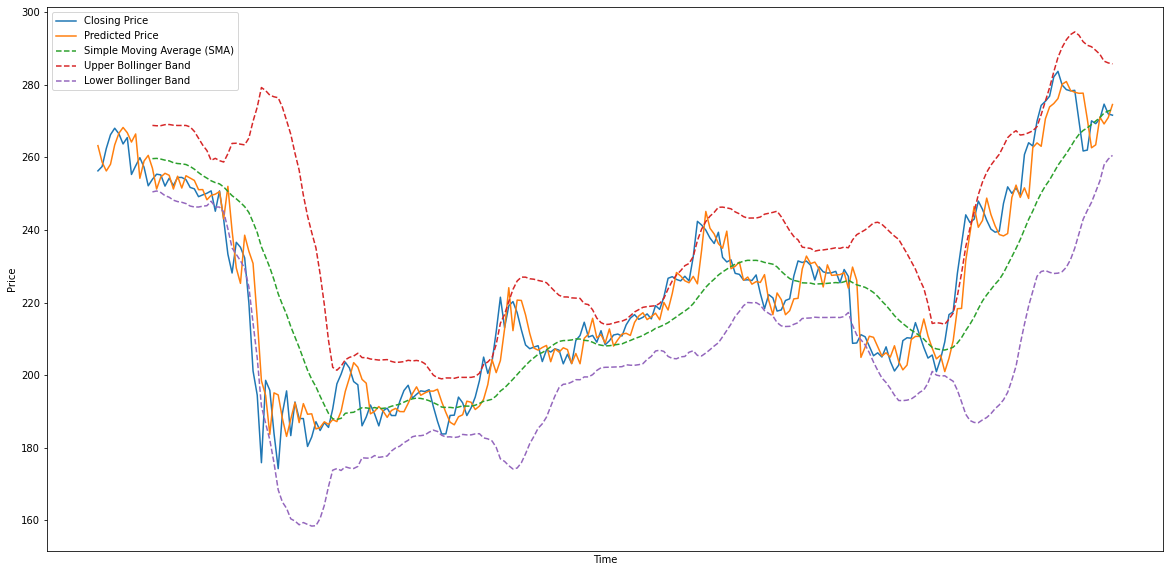

In [17]:
plt.figure(figsize=(20, 10))
plt.plot(date_train_daily, train_data_russia['Price'][6:], label='Closing Price')
plt.plot(date_train_daily, y_train_pred_daily, label='Predicted Price')
plt.plot(date_train_daily, sma_train_daily[6:], label='Simple Moving Average (SMA)', linestyle='--')
plt.plot(date_train_daily, boll_up_train_daily[6:], label='Upper Bollinger Band', linestyle='--')
plt.plot(date_train_daily, boll_down_train_daily[6:], label='Lower Bollinger Band', linestyle='--')

plt.xlabel('Time')
plt.xticks([])
plt.ylabel('Price')
plt.legend()
plt.show()

In [18]:
y_test_pred_daily = model_daily(X_test_daily)

test_loss = loss_fn(y_test_pred_daily, y_test_daily)
print(f'Scaled Test MSE: {test_loss}')

y_test_daily = scale_back(y_test_daily, original_max_test, original_min_test)
y_test_pred_daily = scale_back(y_test_pred_daily, original_max_test, original_min_test)
test_data_russia['Price'] = scale_back(test_data_russia['Price'], original_max_test, original_min_test)

y_test_daily = y_test_daily.detach().numpy()
y_test_pred_daily = y_test_pred_daily.detach().numpy()

Scaled Test MSE: 0.014385415241122246


In [19]:
test_data_russia.head()

,Date,Price,Open,High,Low,Vol.,Change %,quarter,month,week
249,2021-01-04,272.00,274.67,276.60,270.61,48920000.0,0.13%,1,1,1
250,2021-01-05,275.20,272.69,275.70,270.28,45580000.0,1.18%,1,1,1
251,2021-01-06,272.93,275.94,275.94,271.62,40950000.0,-0.82%,1,1,1
252,2021-01-08,283.64,275.11,283.99,275.11,88930000.0,3.92%,1,1,1
253,2021-01-11,289.49,282.86,292.95,279.48,112350000.0,2.06%,1,1,2


In [20]:
sma_test_daily, boll_up_test_daily, boll_down_test_daily = get_bollinger_bands(pd.concat([train_data_russia[-20:]['Price'], test_data_russia['Price']]))

In [21]:
date_test_daily_ = np.concatenate((date_train_daily[-20:], date_test_daily), axis=0)

In [22]:
y_test_daily_ = np.concatenate((y_train_daily[-20:], y_test_daily), axis=0)
y_test_pred_daily_ = np.concatenate((y_train_pred_daily[-20:], y_test_pred_daily), axis=0)

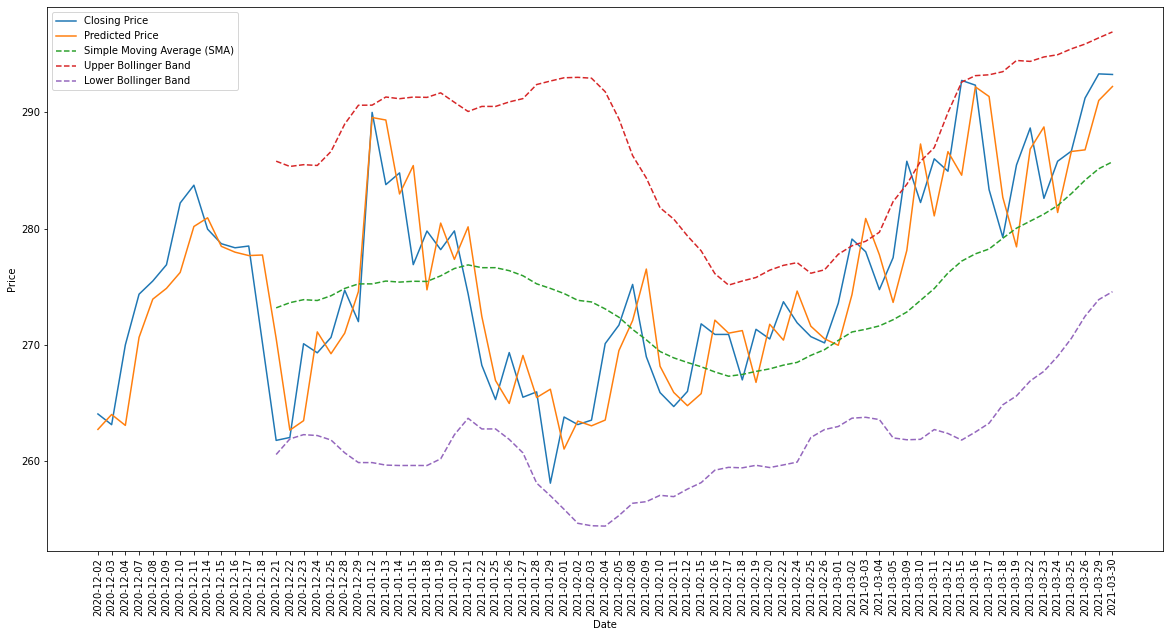

In [23]:
plt.figure(figsize=(20, 10))
plt.plot(date_test_daily_, y_test_daily_, label='Closing Price')
plt.plot(date_test_daily_, y_test_pred_daily_, label='Predicted Price')
plt.plot(date_test_daily_, sma_test_daily[6:], label='Simple Moving Average (SMA)', linestyle='--')
plt.plot(date_test_daily_, boll_up_test_daily[6:], label='Upper Bollinger Band', linestyle='--')
plt.plot(date_test_daily_, boll_down_test_daily[6:], label='Lower Bollinger Band', linestyle='--')
plt.xlabel('Date')
plt.xticks(rotation=90)
plt.ylabel('Price')
plt.legend()
plt.show()

In [ ]:
## buy when predicted price is lower than the lower bollinger band
## sell when predicted price is higher than the upper bollinger band

In [24]:
boll_df_daily = pd.DataFrame({'Date': date_test_daily_})

In [25]:
boll_df_daily['Predicted Closing Price'] = y_test_pred_daily_
boll_df_daily['Actual Closing Price'] = y_test_daily_
boll_df_daily['sma'] = np.array(sma_test_daily[6:])
boll_df_daily['upper_band'] = np.array(boll_up_test_daily[6:])
boll_df_daily['lower_band'] = np.array(boll_down_test_daily[6:])

In [26]:
boll_df_daily = boll_df_daily[boll_df_daily['Date'] >= '2021-01-04'].copy()

In [27]:
boll_df_daily.head()

,Date,Predicted Closing Price,Actual Closing Price,sma,upper_band,lower_band
20,2021-01-12,289.549988,289.989990,275.2465,290.613304,259.879696
21,2021-01-13,289.334473,283.779968,275.4885,291.312817,259.664183
22,2021-01-14,282.974670,284.789978,275.3985,291.166285,259.630715
23,2021-01-15,285.418884,276.899994,275.4705,291.308028,259.632972
24,2021-01-18,274.732880,279.789978,275.4550,291.280647,259.629353


In [28]:
buy_ids_daily = boll_df_daily[boll_df_daily['Predicted Closing Price']  <= boll_df_daily['lower_band']]
buy_ids_daily

,Date,Predicted Closing Price,Actual Closing Price,sma,upper_band,lower_band


In [29]:
sell_ids_daily = boll_df_daily[boll_df_daily['Predicted Closing Price']  >= boll_df_daily['upper_band']]
sell_ids_daily

,Date,Predicted Closing Price,Actual Closing Price,sma,upper_band,lower_band
56,2021-03-03,280.869385,278.009979,271.3430,278.911152,263.774848
60,2021-03-10,287.274384,282.239990,273.8305,285.780352,261.880648


In [30]:
train_data_russia.head()

,Date,Price,Open,High,Low,Vol.,Change %,quarter,month,week
0,2020-01-06,253.90,254.75,254.84,251.40,22350000.0,-0.43%,1,1,2
1,2020-01-08,259.15,253.57,259.15,253.03,40820000.0,2.07%,1,1,2
2,2020-01-09,257.99,259.40,261.76,257.01,38330000.0,-0.45%,1,1,2
3,2020-01-10,258.19,257.86,259.25,256.88,18850000.0,0.08%,1,1,2
4,2020-01-13,262.40,258.30,262.40,257.15,25860000.0,1.63%,1,1,3


In [31]:
week_counts = train_data_russia['week'].value_counts()
week_values = week_counts[week_counts == 5].index.tolist()
week_values_df = train_data_russia[train_data_russia['week'].isin(week_values)]

In [32]:
week_values_df.head(n=10)

,Date,Price,Open,High,Low,Vol.,Change %,quarter,month,week
4,2020-01-13,262.40,258.30,262.40,257.15,25860000.0,1.63%,1,1,3
5,2020-01-14,259.05,262.50,263.22,258.62,31130000.0,-1.28%,1,1,3
6,2020-01-15,256.31,258.49,258.91,254.21,49360000.0,-1.06%,1,1,3
7,2020-01-16,257.51,257.11,259.51,256.10,40250000.0,0.47%,1,1,3
8,2020-01-17,262.50,258.20,262.82,257.75,44910000.0,1.94%,1,1,3
9,2020-01-20,266.28,263.20,266.97,261.80,29800000.0,1.44%,1,1,4
10,2020-01-21,268.06,265.50,268.90,263.02,38080000.0,0.67%,1,1,4
11,2020-01-22,266.54,268.72,270.80,265.50,44280000.0,-0.57%,1,1,4
12,2020-01-23,263.73,264.64,266.89,262.24,40600000.0,-1.05%,1,1,4
13,2020-01-24,265.49,264.50,267.50,264.21,27340000.0,0.67%,1,1,4


In [33]:
week_values_df.shape

(210, 10)

In [34]:
# save the min and max values of the original data
original_min_weekly = week_values_df['Price'].min()
original_max_weekly = week_values_df['Price'].max()

In [ ]:
## scale the data
week_values_df['Price'] = scaler_minmax.fit_transform(week_values_df[['Price']])

In [36]:
## get the weekly data
X_train_weekly, y_train_weekly, date_train_weekly = get_weekly_data(week_values_df, 5)

In [37]:
X_train_weekly[0]

array([0.8051343 , 0.77452951, 0.74949753, 0.76046044, 0.80604787])

In [38]:
y_train_weekly[0]

array([0.84058103, 0.85684268, 0.84295633, 0.81728485, 0.83336379])

In [39]:
X_train_weekly[1]

array([0.84058103, 0.85684268, 0.84295633, 0.81728485, 0.83336379])

In [40]:
y_train_weekly[1]

array([0.74045313, 0.76219624, 0.78266033, 0.75863329, 0.71194957])

In [41]:
X_train_weekly[2]

array([0.74045313, 0.76219624, 0.78266033, 0.75863329, 0.71194957])

In [42]:
y_train_weekly[2]

array([0.72830258, 0.74118399, 0.73935684, 0.71112735, 0.73113466])

In [43]:
## convert numpy arrays to tensors and reshape them to feed the LSTM 
X_train_weekly, y_train_weekly = numpy2tensor(X_train_weekly, y_train_weekly, daily=False)

In [44]:
X_train_weekly.shape

torch.Size([41, 5, 1])

In [ ]:
y_train_weekly.shape

torch.Size([41, 5])

In [45]:
lf = nn.MSELoss(reduction='mean')

In [46]:
input_size_weekly = 1
hidden_size_weekly = 128
num_layers_weekly = 2
output_size_weekly = 5
lr_weekly = 0.01

model_weekly = LSTMModel(input_size_weekly, hidden_size_weekly, num_layers_weekly, output_size_weekly)

model_weekly = train(X_train_weekly, y_train_weekly, model_weekly, lr_weekly, lf, epochs=200)

Epoch [100/200], Loss: 0.0117
Epoch [200/200], Loss: 0.0102


In [ ]:
y_train_pred_weekly = model_weekly(X_train_weekly)

# manually scale back the data using the original min and max values
y_train_weekly = scale_back(y_train_weekly, original_max_weekly, original_min_weekly)
y_train_pred_weekly = scale_back(y_train_pred_weekly, original_max_weekly, original_min_weekly)
week_values_df['Price'] = scale_back(week_values_df['Price'], original_max_weekly, original_min_weekly)

y_train_weekly = y_train_weekly.detach().numpy()
y_train_pred_weekly = y_train_pred_weekly.detach().numpy()

In [48]:
y_train_pred_weekly.shape

(41, 5)

In [49]:
sma_train_weekly, boll_up_train_weekly, boll_down_train_weekly = get_bollinger_bands(week_values_df['Price'], 5)

In [50]:
y_train_weekly.reshape(-1).shape

(205,)

In [51]:
sma_train_weekly.shape

(210,)

In [ ]:
week_values_df['Date'].shape

(210,)

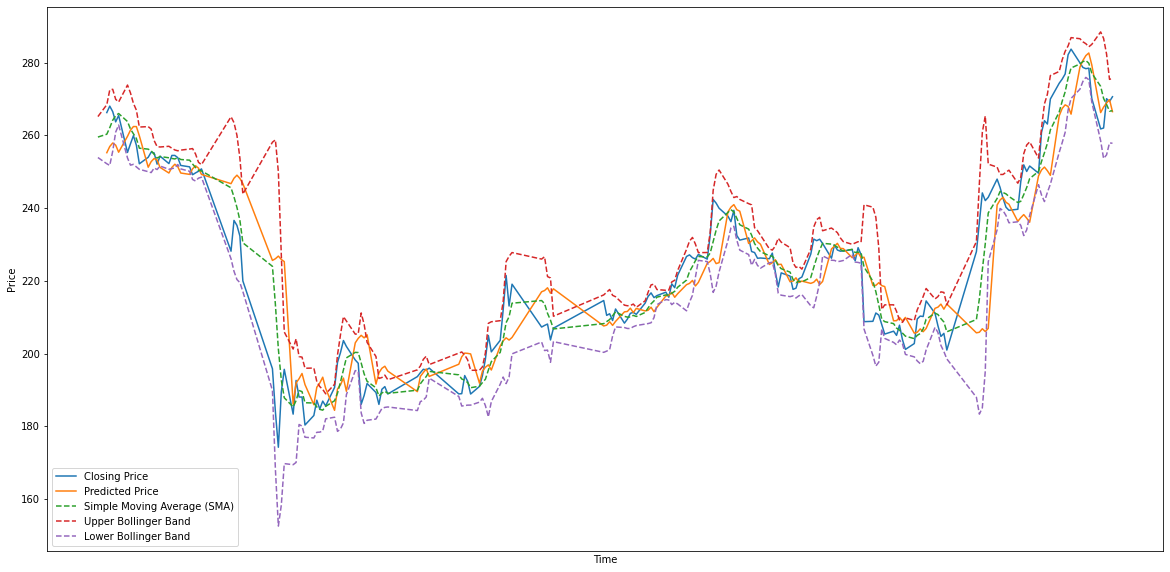

In [52]:
plt.figure(figsize=(20, 10))
plt.plot(week_values_df['Date'][5:], y_train_weekly.reshape(-1), label='Closing Price')
plt.plot(week_values_df['Date'][5:], y_train_pred_weekly.reshape(-1), label='Predicted Price')
plt.plot(week_values_df['Date'], sma_train_weekly, label='Simple Moving Average (SMA)', linestyle='--')
plt.plot(week_values_df['Date'], boll_up_train_weekly, label='Upper Bollinger Band', linestyle='--')
plt.plot(week_values_df['Date'], boll_down_train_weekly, label='Lower Bollinger Band', linestyle='--')

plt.xlabel('Time')
plt.xticks([])
plt.ylabel('Price')
plt.legend()
plt.show()

In [53]:
week_counts_test = test_data_russia['week'].value_counts()
week_values_test = week_counts_test[week_counts_test == 5].index.tolist()
week_values_df_test = test_data_russia[test_data_russia['week'].isin(week_values_test)]

In [54]:
week_values_df_test.head(n=10)

,Date,Price,Open,High,Low,Vol.,Change %,quarter,month,week
253,2021-01-11,289.49,282.86,292.95,279.48,112350000.0,2.06%,1,1,2
254,2021-01-12,289.99,290.88,296.07,286.70,78960000.0,0.17%,1,1,2
255,2021-01-13,283.78,291.01,292.46,283.10,67560000.0,-2.14%,1,1,2
256,2021-01-14,284.79,284.00,286.90,279.06,74670000.0,0.36%,1,1,2
257,2021-01-15,276.90,282.55,286.16,276.00,73770000.0,-2.77%,1,1,2
258,2021-01-18,279.79,275.72,281.30,272.95,73940000.0,1.04%,1,1,3
259,2021-01-19,278.19,280.98,282.80,276.42,56000000.0,-0.57%,1,1,3
260,2021-01-20,279.80,278.62,282.49,276.77,47940000.0,0.58%,1,1,3
261,2021-01-21,274.40,280.75,281.54,272.84,83800000.0,-1.93%,1,1,3
262,2021-01-22,268.25,273.00,273.30,266.78,87010000.0,-2.24%,1,1,3


In [55]:
week_values_df_test.shape

(40, 10)

In [56]:
# manually scale back the data using the original min and max values
# save the min and max values of the original data
original_min_test_weekly = week_values_df_test['Price'].min()
original_max_test_weekly = week_values_df_test['Price'].max()

In [ ]:
## scale the data
week_values_df_test['Price'] = scaler_minmax.fit_transform(week_values_df_test[['Price']])

In [58]:
## get the weekly data
X_test_weekly, y_test_weekly, date_test_weekly = get_weekly_data(week_values_df_test, 5)

In [59]:
X_test_weekly, y_test_weekly = numpy2tensor(X_test_weekly, y_test_weekly, daily=False)

In [ ]:
y_test_pred_weekly = model_weekly(X_test_weekly)

test_loss_weekly = lf(y_test_pred_weekly, y_test_weekly)
print(f'Scaled Test MSE: {test_loss_weekly}')


y_test_weekly = scale_back(y_test_weekly, original_max_test_weekly, original_min_test_weekly)
y_test_pred_weekly = scale_back(y_test_pred_weekly, original_max_test_weekly, original_min_test_weekly)
week_values_df_test['Price'] = scale_back(week_values_df_test['Price'], original_max_test_weekly, original_min_test_weekly)

y_test_weekly = y_test_weekly.detach().numpy()
y_test_pred_weekly = y_test_pred_weekly.detach().numpy()

In [61]:
sma_test_weekly, boll_up_test_weekly, boll_down_test_weekly = get_bollinger_bands(week_values_df_test['Price'], 5)

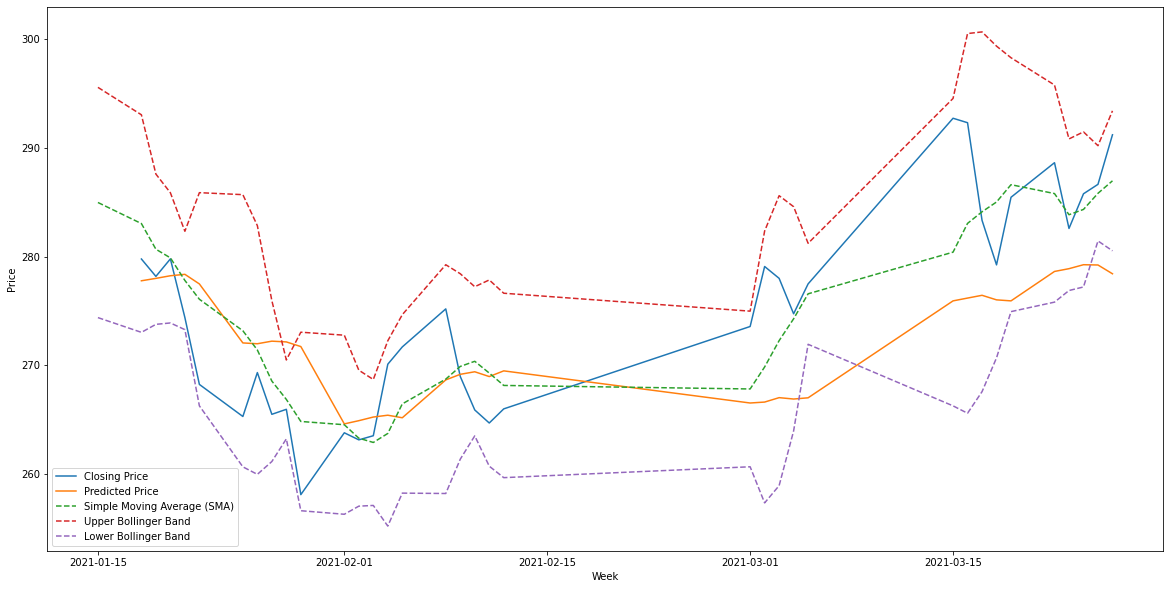

In [62]:
plt.figure(figsize=(20, 10))
plt.plot(week_values_df_test['Date'][5:], y_test_weekly.reshape(-1), label='Closing Price')
plt.plot(week_values_df_test['Date'][5:], y_test_pred_weekly.reshape(-1), label='Predicted Price')
plt.plot(week_values_df_test['Date'], sma_test_weekly, label='Simple Moving Average (SMA)', linestyle='--')
plt.plot(week_values_df_test['Date'], boll_up_test_weekly, label='Upper Bollinger Band', linestyle='--')
plt.plot(week_values_df_test['Date'], boll_down_test_weekly, label='Lower Bollinger Band', linestyle='--')

plt.xlabel('Week')
plt.ylabel('Price')
plt.legend()
plt.show()

In [63]:
boll_df_weekly = pd.DataFrame({'Week': week_values_df_test['Date'][5:]})

In [64]:
boll_df_weekly['Predicted Closing Price'] = y_test_pred_weekly.reshape(-1)
boll_df_weekly['Actual Closing Price'] = y_test_weekly.reshape(-1)
boll_df_weekly['sma'] = np.array(sma_test_weekly[5:])
boll_df_weekly['upper_band'] = np.array(boll_up_test_weekly[5:])
boll_df_weekly['lower_band'] = np.array(boll_down_test_weekly[5:])

In [65]:
buy_ids_weekly = boll_df_weekly[boll_df_weekly['Predicted Closing Price']  <= boll_df_weekly['lower_band']]
buy_ids_weekly

,Week,Predicted Closing Price,Actual Closing Price,sma,upper_band,lower_band
292,2021-03-05,267.018738,277.500000,276.588,281.234534,271.941466
305,2021-03-25,279.238892,286.659973,285.834,290.216387,281.451613
306,2021-03-26,278.430511,291.219971,286.984,293.423668,280.544332


In [66]:
sell_ids_weekly = boll_df_weekly[boll_df_weekly['Predicted Closing Price']  >= boll_df_weekly['upper_band']]
sell_ids_weekly

,Week,Predicted Closing Price,Actual Closing Price,sma,upper_band,lower_band
266,2021-01-28,272.161011,265.959991,266.87,270.499766,263.240234


In [67]:
month_values_ = month_counts[month_counts == maxdays].index.tolist()
month_values_df_ = train_data_russia[train_data_russia['month'].isin(month_values_)]

month_values_mt = month_counts[month_counts > maxdays].index.tolist()
month_values_df_mt = train_data_russia[train_data_russia['month'].isin(month_values_mt)]

In [68]:
month_values_df_mt.head()

,Date,Price,Open,High,Low,Vol.,Change %,quarter,month,week
38,2020-03-02,228.17,238.93,241.00,218.86,101990000.0,-2.22%,1,3,10
39,2020-03-03,236.63,233.00,239.00,232.28,83650000.0,3.71%,1,3,10
40,2020-03-04,235.27,234.13,236.70,232.62,54270000.0,-0.57%,1,3,10
41,2020-03-05,232.33,237.00,238.72,230.64,57080000.0,-1.25%,1,3,10
42,2020-03-06,219.99,228.00,229.20,216.67,104450000.0,-5.31%,1,3,10


In [69]:
for month in month_values_df_mt['month'].unique():
 df =  month_values_df_mt[month_values_df_mt['month'] == month][:maxdays]
 month_values_df_ = pd.concat((month_values_df_, df), axis=0)

In [ ]:
month_values_df_.shape

(228, 10)

In [70]:
month_values_df_.sort_values(by=['Date'],inplace=True)

In [71]:
# save the min and max values of the original data
original_min_monthly = month_values_df_['Price'].min()
original_max_monthly = month_values_df_['Price'].max()

In [72]:
## scale the data
month_values_df_['Price'] = scaler_minmax.fit_transform(month_values_df_[['Price']])

In [73]:
## get the monthly data
X_train_monthly, y_train_monthly, date_train_monthly = get_monthly_data(month_values_df_, time_step=maxdays, maxdays=maxdays)

In [74]:
## convert numpy arrays to tensors and reshape them to feed the LSTM 
X_train_monthly, y_train_monthly = numpy2tensor(X_train_monthly, y_train_monthly, daily=False)

In [75]:
X_train_monthly.shape

torch.Size([11, 19, 1])

In [76]:
y_train_monthly.shape

torch.Size([11, 19])

In [77]:
input_size_monthly = 1
hidden_size_monthly = 16
num_layers_monthly = 2
output_size_monthly = maxdays
lr_monthly = 0.01

model_monthly = LSTMModel(input_size_monthly, hidden_size_monthly, num_layers_monthly, output_size_monthly)

model_monthly = train(X_train_monthly, y_train_monthly, model_monthly, lr_monthly, lf, epochs=200)

Epoch [100/200], Loss: 0.0168
Epoch [200/200], Loss: 0.0014


In [78]:
y_train_pred_monthly = model_monthly(X_train_monthly)

# manually scale back the data using the original min and max values
y_train_monthly = scale_back(y_train_monthly, original_max_monthly, original_min_monthly)
y_train_pred_monthly = scale_back(y_train_pred_monthly, original_max_monthly, original_min_monthly)
month_values_df_['Price'] = scale_back(month_values_df_['Price'], original_max_monthly, original_min_monthly)

y_train_monthly = y_train_monthly.detach().numpy()
y_train_pred_monthly = y_train_pred_monthly.detach().numpy()

In [79]:
sma_train_monthly, boll_up_train_monthly, boll_down_train_monthly = get_bollinger_bands(month_values_df_['Price'], maxdays)

In [80]:
boll_up_train_monthly.shape

(228,)

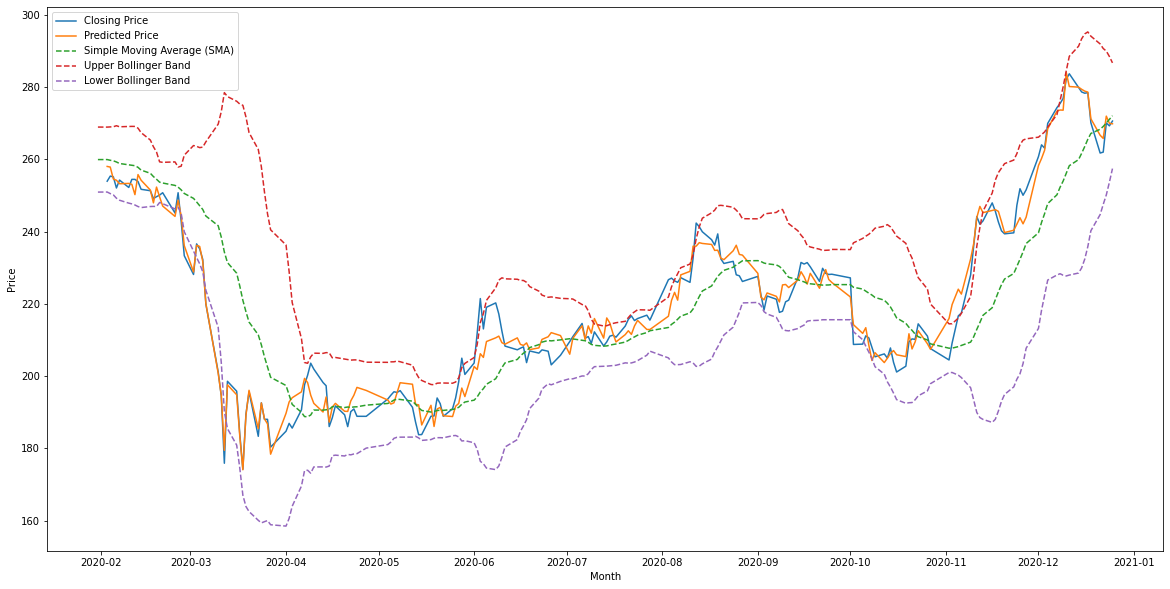

In [81]:
plt.figure(figsize=(20, 10))
plt.plot(month_values_df_['Date'][maxdays:], y_train_monthly.reshape(-1), label='Closing Price')
plt.plot(month_values_df_['Date'][maxdays:], y_train_pred_monthly.reshape(-1), label='Predicted Price')
plt.plot(month_values_df_['Date'], sma_train_monthly, label='Simple Moving Average (SMA)', linestyle='--')
plt.plot(month_values_df_['Date'], boll_up_train_monthly, label='Upper Bollinger Band', linestyle='--')
plt.plot(month_values_df_['Date'], boll_down_train_monthly, label='Lower Bollinger Band', linestyle='--')

plt.xlabel('Month')
plt.ylabel('Price')
plt.legend()
plt.show()

In [82]:
test_data_russia['month'].value_counts()

3    22
2    20
1    19
Name: month, dtype: int64

In [83]:
month_values_test = month_counts_test[month_counts_test == maxdays_test].index.tolist()
month_values_df_test = test_data_russia[test_data_russia['month'].isin(month_values_test)]

month_values_mt_test = month_counts_test[month_counts_test > maxdays_test].index.tolist()
month_values_df_mt_test = test_data_russia[test_data_russia['month'].isin(month_values_mt_test)]

In [84]:
for month in month_values_df_mt_test['month'].unique():
 df_ =  month_values_df_mt_test[month_values_df_mt_test['month'] == month][:maxdays_test]
 month_values_df_test = pd.concat((month_values_df_test, df_), axis=0)

In [85]:
month_values_df_test.sort_values(by=['Date'],inplace=True)

In [86]:
# save the min and max values of the original data
original_min_test_monthly = month_values_df_test['Price'].min()
original_max_test_monthly = month_values_df_test['Price'].max()

In [87]:
## scale the data
month_values_df_test['Price'] = scaler_minmax.fit_transform(month_values_df_test[['Price']])

In [88]:
## get the monthly data
X_test_monthly, y_test_monthly, date_test_monthly = get_monthly_data(month_values_df_test, time_step=maxdays_test, maxdays=maxdays_test)

In [89]:
## convert numpy arrays to tensors and reshape them to feed the LSTM 
X_test_monthly, y_test_monthly = numpy2tensor(X_test_monthly, y_test_monthly, daily=False)

In [90]:
y_test_pred_monthly = model_monthly(X_test_monthly)

test_loss_monthly = lf(y_test_pred_monthly, y_test_monthly)
print(f'Scaled Test MSE: {test_loss_monthly}')

y_test_monthly = scale_back(y_test_monthly, original_max_test_monthly, original_min_test_monthly)
y_test_pred_monthly = scale_back(y_test_pred_monthly, original_max_test_monthly, original_min_test_monthly)
month_values_df_test['Price'] = scale_back(month_values_df_test['Price'], original_max_test_monthly, original_min_test_monthly)

y_test_monthly = y_test_monthly.detach().numpy()
y_test_pred_monthly = y_test_pred_monthly.detach().numpy()

Scaled Test MSE: 0.05348633602261543


In [91]:
sma_test_monthly, boll_up_test_monthly, boll_down_test_monthly = get_bollinger_bands(month_values_df_test['Price'], maxdays_test)

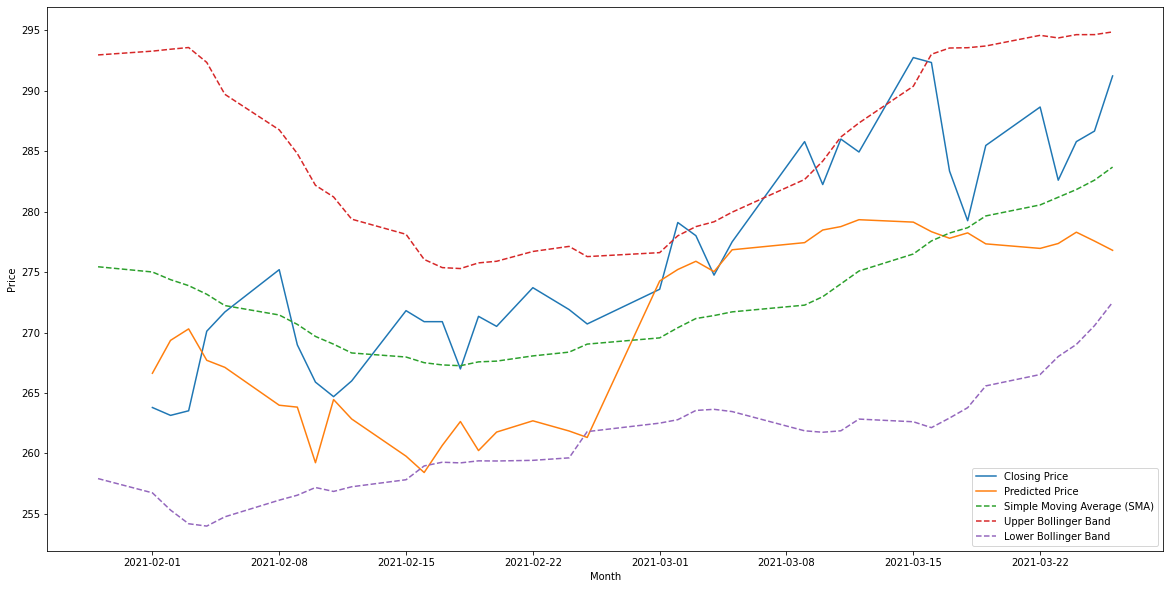

In [92]:
plt.figure(figsize=(20, 10))
plt.plot(month_values_df_test['Date'][maxdays_test:], y_test_monthly.reshape(-1),label='Closing Price')
plt.plot(month_values_df_test['Date'][maxdays_test:], y_test_pred_monthly.reshape(-1), label='Predicted Price')
plt.plot(month_values_df_test['Date'], sma_test_monthly, label='Simple Moving Average (SMA)', linestyle='--')
plt.plot(month_values_df_test['Date'], boll_up_test_monthly, label='Upper Bollinger Band', linestyle='--')
plt.plot(month_values_df_test['Date'], boll_down_test_monthly, label='Lower Bollinger Band', linestyle='--')

plt.xlabel('Month')
plt.ylabel('Price')
plt.legend()
plt.show()

In [93]:
boll_df_monthly = pd.DataFrame({'Month': month_values_df_test['Date'][maxdays_test:]})

In [94]:
boll_df_monthly['Predicted Closing Price'] = y_test_pred_monthly.reshape(-1)
boll_df_monthly['Actual Closing Price'] = y_test_monthly.reshape(-1)
boll_df_monthly['sma'] = np.array(sma_test_monthly[maxdays_test:])
boll_df_monthly['upper_band'] = np.array(boll_up_test_monthly[maxdays_test:])
boll_df_monthly['lower_band'] = np.array(boll_down_test_monthly[maxdays_test:])

In [95]:
boll_df_monthly.head()

,Month,Predicted Closing Price,Actual Closing Price,sma,upper_band,lower_band
268,2021-02-01,266.632935,263.799988,275.008421,293.272337,256.744505
269,2021-02-02,269.352356,263.149994,274.374211,293.429750,255.318671
270,2021-02-03,270.301697,263.529999,273.879474,293.570824,254.188124
271,2021-02-04,267.705231,270.109985,273.167368,292.340138,253.994599
272,2021-02-05,267.120483,271.699982,272.231053,289.700046,254.762059


In [96]:
buy_ids_monthly = boll_df_monthly[boll_df_monthly['Predicted Closing Price']  <= boll_df_monthly['lower_band']]
buy_ids_monthly

,Month,Predicted Closing Price,Actual Closing Price,sma,upper_band,lower_band
279,2021-02-16,258.425049,270.899994,267.507368,276.045294,258.969443
286,2021-02-25,261.324982,270.709991,269.044211,276.280521,261.807900


In [97]:
sell_ids_monthly = boll_df_monthly[boll_df_monthly['Predicted Closing Price']  >= boll_df_monthly['upper_band']]
sell_ids_monthly

,Month,Predicted Closing Price,Actual Closing Price,sma,upper_band,lower_band
